### Project Description

In this project the task is to predict the price of flats in some unknown city. There are two datasets given: train.csv (contains all features and prices of flats) and test.csv (only features).<br>
The initial features are as follows:<br>
**Id** - id-number of te flat<br>
**DistrictId** - id-number of the district<br>
**Rooms** - number of rooms<br>
**Square** - total square meters<br>
**LifeSquare** - square meters of the living space<br>
**KitchenSquare** - square meters of the kitchen<br>
**Floor** - floor<br>
**HouseFloor** - number of floors in the house<br>
**HouseYear** - year of construction<br>
**Ecology_1, Ecology_2, Ecology_3** - ecological features of the surroundings<br>
**Social_1, Social_2, Social_3** - social features of the surroundings <br>
**Healthcare_1, Helthcare_2** - healthcare features of the surroundings <br>
**Shops_1, Shops_2** - econimical/entertainment features of the surroundings <br>
**Price** - price of the flat<br>
The link to the competition: https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528

### Data Analysis

##### Upload of the data and needed libraries

In [107]:
import numpy as np
import pandas as pd
import pickle
import random
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams["figure.figsize"] = 5, 3
rcParams.update({"font.size": 14})
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
SUBMIT_DATASET_PATH = 'sample_submission.csv'

REPORTS_FILE_PATH = './reports/'
MODEL_FILE_PATH = './models/'

In [3]:
X = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

##### Data processing. Data Upload

First, we can reduce the memory usage, applying new types to data, suitable for their format

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
reduce_mem_usage(X)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0     11809          27    3.0  115.027313         NaN           10.0      4   
1      3013          22    1.0   39.832523   23.169222            8.0      7   
2      8215           1    3.0   78.342216   47.671970           10.0      2   
3      2352           1    1.0   40.409908         NaN            1.0     10   
4     13866          94    2.0   64.285065   38.562515            9.0     16   
...     ...         ...    ...         ...         ...            ...    ...   
9995   1260          61    2.0   49.090729   33.272625            6.0      3   
9996  16265          27    2.0   64.307686   37.038422            9.0     13   
9997   2795         178    1.0   29.648056   16.555363            5.0      3   
9998  14561          21    1.0   32.330292   22.326870            5.0      3   
9999   7202          94    1.0   35.815475   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
0           10.0       2014   0.075424         B         B        11   
1            8.0       1966   0.118537         B         B        30   
2           17.0       1988   0.025609         B         B        33   
3           22.0       1977   0.007122         B         B         1   
4           16.0       1972   0.282798         B         B        33   
...          ...        ...        ...       ...       ...       ...   
9995        12.0       1981   0.300323         B         B        52   
9996         0.0       1977   0.072158         B         B         2   
9997         5.0       1958   0.460556         B         B        20   
9998         9.0       1969   0.194489         B         B        47   
9999         9.0       1975   0.127376         B         B        43   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
0         3097         0           NaN            0        0       B   
1         6207         1        1183.0            1        0       B   
2         5261         0         240.0            3        1       B   
3          264         0           NaN            0        1       B   
4         8667         2           NaN            0        6       B   
...        ...       ...           ...          ...      ...     ...   
9995     10311         6           NaN            1        9       B   
9996       629         1           NaN            0        0       A   
9997      4386        14           NaN            1        5       B   
9998      8004         3         125.0            3        5       B   
9999      8429         3           NaN            3        9       B   

              Price  
0     305018.875000  
1     177734.546875  
2     282078.718750  
3     168106.000000  
4     343995.093750  
...             ...  
9995  119367.453125  
9996  199715.156250  
9997  165953.906250  
9998  171842.406250  
9999  177685.625000  

[10000 rows x 20 columns]

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [8]:
X = X.astype({'Rooms': np.int16, 'HouseFloor': np.int8})

##### Data processing. Filling NaNs

As we can see, features LifeSquare and Healthcare_1 include NaN. As there are significant amount of NaN in potentially important features, it is needed to fill in all these NaNs. They can be filled in with medians of the whole dataset. However, if we apply median for such a big number of NaNs (~25% for LifeSquare and ~45% for Healthcare_1) these features will be useless, as the mode will always tend to median value. So we need to fill NaNs with median of some meaningful aggregation. To find that aggregation we need to see the correlation between these two factors with others

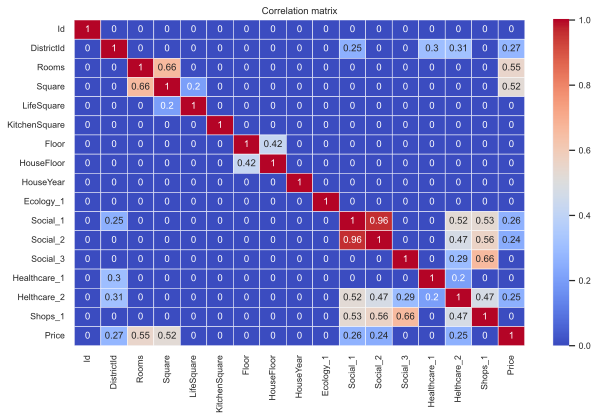

In [9]:
plt.figure(figsize=(9, 6))

sns.set(font_scale=0.8)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

We see that there is quite good correlation between LifeSquare and Square features. There is also quite nice correlation between Healthcare_1 and DistrictId as well as with Helthcare_2. So we can fill in all Nans with medians based on aggregation per correlative feature. First, let's proceed with Healthcare_1

In [10]:
X['LifeSquare_nan'] = 0
X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

X['Healthcare_1_nan'] = 0
X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1

In [11]:
df_pivot_hc = pd.pivot_table(data=X,
               values='Healthcare_1',
               index='DistrictId',
               aggfunc=[np.median, lambda x: len(x.dropna())])
df_pivot_hc

median     <lambda>
           Healthcare_1 Healthcare_1
DistrictId                          
0                2857.0           48
1                 240.0           57
2                 990.0           59
3                  30.0           82
4                2500.0           11
...                 ...          ...
202              4702.0            2
205                 NaN            0
207              1815.0            1
208                 NaN            0
209              2729.0            1

[205 rows x 2 columns]

Let's assume that for reasonable filling we need at least 5 non-NaN observations per each feature. Created data frames will be a base for our filling.

In [12]:
healthcare1_for_nans = df_pivot_hc[(df_pivot_hc['<lambda>', 'Healthcare_1'] > 4)]['median']['Healthcare_1']

In [13]:
for i in list(healthcare1_for_nans.index):
    X.loc[X['DistrictId']==i, 'Healthcare_1'] = X.loc[X['DistrictId']==i, 'Healthcare_1'].fillna(healthcare1_for_nans[i])

In [14]:
X['Healthcare_1'].isna().sum()

2786

In [15]:
healthcare1_for_nans2 = X.groupby('Helthcare_2').median()['Healthcare_1']

In [16]:
for i in list(healthcare1_for_nans2.index):
    X.loc[X['Helthcare_2']==i, 'Healthcare_1'] = X.loc[X['Helthcare_2']==i, 'Healthcare_1'].fillna(healthcare1_for_nans2[i])

In [17]:
X['Healthcare_1'].isna().sum()

0

Let's proceed further with LifeSquare. In order to make aggrgation by Square we would need to create another category feature out of 'real' Square feature. Categorization will be made based on std, meaning each category will have interval of 20 m^2

In [18]:
square_cat = pd.cut(X['Square'], bins = (-1, 30, 50, 70, 90, 110, 10000), labels = False)
square_cat

0       5
1       1
2       3
3       1
4       2
       ..
9995    1
9996    2
9997    0
9998    1
9999    1
Name: Square, Length: 10000, dtype: int64

In [19]:
lifesquare_for_nans = X.groupby(square_cat).median()['LifeSquare']

In [20]:
square_cat.replace(lifesquare_for_nans.index, lifesquare_for_nans, inplace = True)

In [21]:
X['LifeSquare'] = X['LifeSquare'].fillna(square_cat)
X['LifeSquare'].isna().sum()

0

##### Data processing. Replacing outliers

In [22]:
X.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.890500     56.315720     36.846348   
std     4859.01902     43.587592      0.839512     21.058716     76.806992   
min        0.00000      0.000000      0.000000      1.136859      0.370619   
25%     4169.50000     20.000000      1.000000     41.774879     23.269314   
50%     8394.50000     36.000000      2.000000     52.513309     33.622883   
75%    12592.50000     75.000000      2.000000     65.900627     45.060482   
max    16798.00000    209.000000     19.000000    641.065186   7480.592285   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560839      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      24.687000   5352.157400      8.039200    980.494202      1.319500   
std       17.532614   4006.799803     23.831875    872.961121      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    540.000000      0.000000   
50%       25.000000   5285.000000      2.000000    730.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1183.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  LifeSquare_nan  Healthcare_1_nan  
count  10000.000000   10000.000000    10000.000000      10000.000000  
mean       4.231300  214138.937500        0.211300          0.479800  
std        4.806341   92872.273438        0.408251          0.499617  
min        0.000000   59174.777344        0.000000          0.000000  
25%        1.000000  153872.628906        0.000000          0.000000  
50%        3.000000  192269.648438        0.000000          0.000000  
75%        6.000000  249135.460938        0.000000          1.000000  
max       23.000000  633233.437500        1.000000          1.000000

We see some clear anomalies with the following parameters: Rooms, Square, LifeSquare, KitchenSquare, HouseFloor. With these parameters we can interpret for sure what should be reasonable value.

In [23]:
X['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [24]:
X['Rooms_outlier'] = 0
X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

X.loc[(X['Rooms'] >= 6) | (X['Rooms'] == 0), 'Rooms'] = X['Rooms'].median()

In [25]:
X['HouseFloor'].value_counts()

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
32        4
37        4
28        3
99        2
39        2
48        2
47        1
38        1
36        1
29        1
44        1
31        1
117       1
45        1
26        1
Name: HouseFloor, dtype: int64

In [26]:
X['HouseFloor_outlier'] = 0
X.loc[(X['HouseFloor']==0) | (X['HouseFloor']>=90),'HouseFloor_outlier'] =  1

X.loc[(X['HouseFloor']==0) | (X['HouseFloor']>=90),'HouseFloor'] =  X['HouseFloor'].median()

In [27]:
X['HouseFloor'].describe()

count    10000.000000
mean        12.931500
std          6.241322
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         48.000000
Name: HouseFloor, dtype: float64

In [28]:
X.loc[(X['Floor'] > X['HouseFloor']),'HouseFloor_outlier'] =  1

X.loc[(X['Floor'] > X['HouseFloor']),'Floor'] = X.loc[(X['Floor'] > X['HouseFloor']),'HouseFloor'].apply(lambda x: random.randint(1,x))

In [29]:
X['Square_outlier'] = 0
X.loc[(X['Square']>150) | (X['Square']<20),'Square_outlier'] =  1

In [30]:
df_sq = X.groupby('Rooms').median()['Square']

for i in list(df_sq.index):
    X.loc[(X['Square']>200) & (X['Rooms']==i), 'Square'] = df_sq[i]
    X.loc[(X['Square']<20) & (X['Rooms']==i), 'Square'] = df_sq[i]

In [31]:
X['Square'].describe()

count    10000.000000
mean        56.207855
std         18.808928
min         20.213127
25%         41.784348
50%         52.539909
75%         65.900627
max        198.930176
Name: Square, dtype: float64

In [32]:
X['LifeSquare_outlier'] = 0
X.loc[(X['LifeSquare']>150) | (X['LifeSquare']<15),'LifeSquare_outlier'] =  1

In [33]:
df_lsq = X.groupby('Rooms').median()['LifeSquare']

for i in list(df_lsq.index):
    X.loc[(X['LifeSquare']>150) & (X['Rooms']==i), 'LifeSquare'] = df_lsq[i]
    X.loc[(X['LifeSquare']<15) & (X['Rooms']==i), 'LifeSquare'] = df_lsq[i]

In [34]:
X['LifeSquare'].describe()

count    10000.000000
mean        36.419064
std         15.549800
min         15.001234
25%         23.269314
50%         33.954399
75%         45.195023
max        138.910187
Name: LifeSquare, dtype: float64

In [35]:
X['KitchenSquare_outlier'] = 0
X.loc[(X['KitchenSquare']>20) | (X['KitchenSquare']<5),'KitchenSquare_outlier'] =  1

In [36]:
condition = (X['KitchenSquare']>20) | (X['KitchenSquare']<5)
X.loc[condition,'KitchenSquare'] = X.loc[~condition,'KitchenSquare'].median()

In [37]:
X['KitchenSquare'].describe()

count    10000.000000
mean         7.993900
std          1.936058
min          5.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         20.000000
Name: KitchenSquare, dtype: float64

In [38]:
X.loc[(X['LifeSquare']>X['Square']),'LifeSquare_outlier'] =  1
X.loc[(X['LifeSquare']>X['Square'])]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
33      847          74      2  73.314972   74.131264            8.0      6   
64     3992           1      3  87.200623   87.730225            8.0     21   
77    11771          45      1  38.467278   39.624493            8.0      9   
100   13343          74      2  79.937668   82.931595            8.0      8   
111   13875          20      1  28.438793   32.514023            6.0      6   
...     ...         ...    ...        ...         ...            ...    ...   
9960  16258          48      3  96.056786   98.152802            8.0      1   
9962  14175          14      1  42.029175   44.682167           10.0      4   
9979   2201           6      1  40.043236   41.984322            8.0      3   
9987  11665           1      2  62.690056   64.602936           10.0     19   
9993   9289           1      3  84.486076   88.931511            8.0      4   

      HouseFloor  HouseYear  Ecology_1  ... Shops_1 Shops_2          Price  \
33             6       1977   0.075779  ...       2       B  254005.375000   
64            22       1977   0.007122  ...       1       B  300180.375000   
77             9       1977   0.195781  ...       2       B  247440.531250   
100           21       1977   0.075779  ...       2       B  226808.750000   
111           10       2014   0.019509  ...       5       B  199248.109375   
...          ...        ...        ...  ...     ...     ...            ...   
9960           1       2017   0.041125  ...      10       B  524365.562500   
9962           4       2018   0.238617  ...       6       B   87556.382812   
9979          17       2014   0.243205  ...       0       B  134888.078125   
9987          22       2018   0.007122  ...       1       B  203908.187500   
9993          22       2016   0.007122  ...       1       B  264213.562500   

      LifeSquare_nan  Healthcare_1_nan  Rooms_outlier  HouseFloor_outlier  \
33                 0                 1              0                   1   
64                 0                 1              0                   0   
77                 0                 1              0                   1   
100                0                 1              0                   0   
111                0                 0              0                   0   
...              ...               ...            ...                 ...   
9960               0                 1              0                   1   
9962               0                 0              0                   0   
9979               0                 0              0                   0   
9987               0                 1              0                   0   
9993               0                 1              0                   0   

      Square_outlier LifeSquare_outlier  KitchenSquare_outlier  
33                 0                  1                      1  
64                 0                  1                      1  
77                 0                  1                      1  
100                0                  1                      1  
111                0                  1                      0  
...              ...                ...                    ...  
9960               0                  1                      1  
9962               0                  1                      0  
9979               0                  1                      1  
9987               0                  1                      0  
9993               0                  1                      1  

[470 rows x 27 columns]

In [39]:
condition = (X['LifeSquare']>X['Square'])
lsq_factor = np.median(X.loc[~condition, 'LifeSquare'] / X.loc[~condition, 'Square'])

In [40]:
X.loc[condition,'LifeSquare'] = X['Square']*lsq_factor

As we cannot identify the logic behind the Ecoligical, Social and Healthcare features, we can simply visualize the outliers for these factors in order to understand if we need to modify these parameters

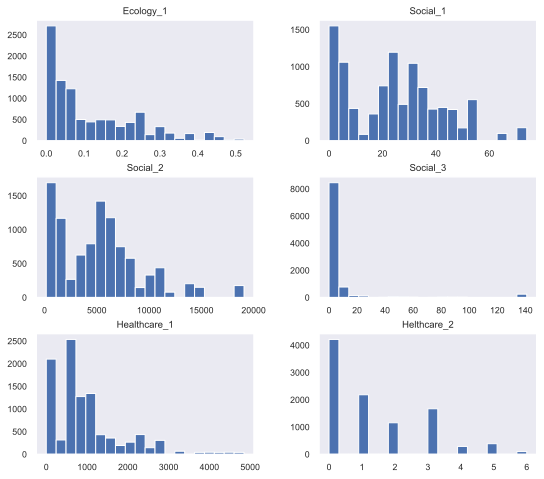

In [41]:
df_num_features = pd.concat([X.filter(like='Ecology'), X.filter(like='Social'), 
                             X['Healthcare_1'], X['Helthcare_2']], axis = 1)
df_num_features.hist(figsize=(8, 8), bins=20, grid=False);

As we can see, Social_3 and Healthcare_1 definitely contain outliers. However, looking on the total unique numbers of Social_3 we can define that it is more a category, than the feature with real number. So for Social_3 we will turn the parameter to category type and for Healthcare_1 we replace outliers with median values

In [42]:
X['Social_3'].nunique()

30

In [43]:
X['Social_3'] = X['Social_3'].astype('category')

In [44]:
max_value = np.quantile(X['Healthcare_1'], q=0.975)
min_value = np.quantile(X['Healthcare_1'], q=0.025)
condition = (X['Healthcare_1'] > max_value) | (X['Healthcare_1'] < min_value)
    
X['Healthcare_1_outlier'] = 0
X.loc[condition, 'Healthcare_1_outlier'] = 1
    
X.loc[condition, 'Healthcare_1'] = X['Healthcare_1'].median()

In [45]:
X['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int32

In [46]:
current_year = datetime.now().year
        
X['HouseYear_outlier'] = 0
X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

In [47]:
class DataPreprocessing:
    """Preprocessing of the initial data"""

    def __init__(self):
        """Parameters of the class"""
        self.medians = None
        self.square_cat = None
        self.square_cat_medians = None
        self.Helthcare_2_medians = None
        self.rooms_medians = None
        self.lsq_factor = None
        self.kitchen_median = None
        self.healthcare_1_quantile_up = None
        self.healthcare_1_quantile_down = None
        
    def fit(self, X):
        """Saving the statistics"""       
        # Calculation of statistics
        self.medians = X.median()
        
        self.square_cat = pd.cut(X['Square'], bins = (0, 30, 50, 70, 90, 110, 10000), labels = False)
        self.lifesquare_for_nans = X.groupby(self.square_cat).median()['LifeSquare']
        self.square_cat.replace(self.lifesquare_for_nans.index, self.lifesquare_for_nans, inplace = True)
        
        self.Helthcare_2_medians = X.groupby('Helthcare_2').median()
        self.rooms_medians = X.groupby('Rooms').median()
        self.lsq_factor = np.median(X['LifeSquare'] / X['Square'])
        self.kitchen_median = X.loc[~((X['KitchenSquare']>20) | (X['KitchenSquare']<5)),'KitchenSquare'].median()
        self.healthcare_1_quantile_up = X['Healthcare_1'].quantile(.975)
        self.healthcare_1_quantile_down = X['Healthcare_1'].quantile(.025)
    
    def transform(self, X):
        """Transformation of data"""
        
        # LifeSquare (with help of additional aggregational feature - square_cat)        
    
        X['LifeSquare_nan'] = 0
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        X['LifeSquare'].fillna(value = self.square_cat, inplace = True)
        
        # Healthcare_1
        X['Healthcare_1_nan'] = 0
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        
        df_pivot_hc = pd.pivot_table(data=X,
               values='Healthcare_1',
               index='DistrictId',
               aggfunc=[np.median, lambda x: len(x.dropna())])
        
        healthcare1_for_nans = df_pivot_hc[(df_pivot_hc['<lambda>', 'Healthcare_1'] > 4)]['median']['Healthcare_1']

        for i in list(map(lambda x: int(x),healthcare1_for_nans.index)):
            X.loc[X['DistrictId']==i, 'Healthcare_1'] = X.loc[X['DistrictId']==i, 'Healthcare_1'].fillna(healthcare1_for_nans[i])

        healthcare1_for_nans2 = self.Helthcare_2_medians['Healthcare_1']

        for i in list(healthcare1_for_nans2.index):
            X.loc[X['Helthcare_2']==i, 'Healthcare_1'] = X.loc[X['Helthcare_2']==i, 'Healthcare_1'].fillna(healthcare1_for_nans2[i])

        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        X.loc[(X['Rooms'] >= 6) | (X['Rooms'] == 0), 'Rooms'] = self.medians['Rooms']
        
        # HouseFloor, Floor
        
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor']==0) | (X['HouseFloor']>=90) | (X['Floor'] > X['HouseFloor']),'HouseFloor_outlier'] =  1

        X.loc[(X['HouseFloor']==0) | (X['HouseFloor']>=90),'HouseFloor'] =  self.medians['HouseFloor']
        X.loc[(X['Floor'] > X['HouseFloor']),'Floor'] = X.loc[(X['Floor'] > X['HouseFloor']),'HouseFloor'].apply(lambda x: random.randint(1,x))
        
        # Square        
        
        X['Square_outlier'] = 0
        condition = (X['Square']>150) | (X['Square']<20)
        X.loc[condition,'Square_outlier'] =  1
        
        df_sq = self.rooms_medians['Square']

        for i in list(df_sq.index):
            X.loc[(condition) & (X['Rooms']==i), 'Square'] = df_sq[i]
        
        # LifeSquare
        
        X['LifeSquare_outlier'] = 0
        condition = (X['LifeSquare']>150) | (X['LifeSquare']<15)
        X.loc[condition | (X['LifeSquare']>X['Square']),'LifeSquare_outlier'] =  1

        df_lsq = self.rooms_medians['LifeSquare']

        for i in list(df_lsq.index):
            X.loc[(condition) & (X['Rooms']==i), 'LifeSquare'] = df_lsq[i]

        X.loc[X['LifeSquare']>X['Square'],'LifeSquare'] = X['Square']*self.lsq_factor
        
        # KitchenSquare
               
        X['KitchenSquare_outlier'] = 0
        condition = (X['KitchenSquare']>20) | (X['KitchenSquare']<5)
        X.loc[condition,'KitchenSquare_outlier'] =  1

        X.loc[condition,'KitchenSquare'] = self.kitchen_median
        
        # Healthcare_1
        
        condition = (X['Healthcare_1'] > self.healthcare_1_quantile_up) | (X['Healthcare_1'] < self.healthcare_1_quantile_down)

        X['Healthcare_1_outlier'] = 0
        X.loc[condition, 'Healthcare_1_outlier'] = 1

        X.loc[condition, 'Healthcare_1'] = self.medians['Healthcare_1']
        
        # Social_3
        
        X['Social_3'] = X['Social_3'].astype(object)
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

##### Data processing. Generation of new features

Feature encoding

In [48]:
X.select_dtypes('category').nunique()

Ecology_2     2
Ecology_3     2
Social_3     30
Shops_2       2
dtype: int64

In [49]:
X['Ecology_2'] = X['Ecology_2'].replace({'A':0, 'B':1})
X['Ecology_3'] = X['Ecology_3'].replace({'A':0, 'B':1})
X['Shops_2'] = X['Shops_2'].replace({'A':0, 'B':1})
X.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  115.027313   81.008728           10.0      4   
1   3013          22      1   39.832523   23.169222            8.0      7   
2   8215           1      3   78.342216   47.671970           10.0      2   
3   2352           1      1   40.409908   23.269314            8.0     10   
4  13866          94      2   64.285065   38.562515            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...          Price  LifeSquare_nan  \
0          10       2014   0.075424  ...  305018.875000               1   
1           8       1966   0.118537  ...  177734.546875               0   
2          17       1988   0.025609  ...  282078.718750               0   
3          22       1977   0.007122  ...  168106.000000               1   
4          16       1972   0.282798  ...  343995.093750               0   

   Healthcare_1_nan  Rooms_outlier HouseFloor_outlier  Square_outlier  \
0                 1              0                  0               0   
1                 0              0                  0               0   
2                 0              0                  0               0   
3                 1              0                  0               0   
4                 1              0                  0               0   

   LifeSquare_outlier  KitchenSquare_outlier  Healthcare_1_outlier  \
0                   0                      0                     0   
1                   0                      0                     0   
2                   0                      0                     0   
3                   0                      1                     0   
4                   0                      0                     0   

   HouseYear_outlier  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 29 columns]

In [50]:
medsocial_2 = X.groupby('Social_3', as_index=False).median()[['Social_3', 'Social_2']]
medsocial_2 = pd.DataFrame(medsocial_2)
medsocial_2.rename(columns={'Social_2': 'MedSocial_2'}, inplace=True)

X = X.merge(medsocial_2, on=['Social_3'])
X.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  115.027313   81.008728           10.0      4   
1   8215           1      3   78.342216   47.671970           10.0      2   
2   2352           1      1   40.409908   23.269314            8.0     10   
3   9951           1      1   46.887894   44.628132            8.0     12   
4   8094           6      3   79.867477   75.085129            8.0      3   

   HouseFloor  HouseYear  Ecology_1  ...  LifeSquare_nan  Healthcare_1_nan  \
0          10       2014   0.075424  ...               1                 1   
1          17       1988   0.025609  ...               0                 0   
2          22       1977   0.007122  ...               1                 1   
3          20       1977   0.007122  ...               0                 1   
4          17       2014   0.243205  ...               0                 0   

   Rooms_outlier  HouseFloor_outlier Square_outlier  LifeSquare_outlier  \
0              0                   0              0                   0   
1              0                   0              0                   0   
2              0                   0              0                   0   
3              0                   0              0                   0   
4              0                   0              0                   0   

   KitchenSquare_outlier  Healthcare_1_outlier  HouseYear_outlier  MedSocial_2  
0                      0                     0                  0       1564.0  
1                      0                     0                  0       1564.0  
2                      1                     0                  0       1564.0  
3                      1                     0                  0       1564.0  
4                      1                     0                  0       1564.0  

[5 rows x 30 columns]

DistrictId is clearly a category, therefore it should be replaced with encoded value. DistrictSize feature will show number of observations in every district

In [51]:
district_size = X.groupby('DistrictId').size()
district_size = pd.DataFrame(district_size)
district_size.rename(columns={0: 'DistrictSize'}, inplace=True)

X = X.merge(district_size, on=['DistrictId'])
X.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  115.027313   81.008728           10.0      4   
1   7757          27      2   58.783661   55.441257           11.0      5   
2  13726          27      1   47.557690   22.682322            8.0      1   
3  13616          27      1   37.340508   37.024632           10.0      8   
4   5720          27      2   66.577164   36.565269            8.0     10   

   HouseFloor  HouseYear  Ecology_1  ...  Healthcare_1_nan  Rooms_outlier  \
0          10       2014   0.075424  ...                 1              0   
1          12       1977   0.011654  ...                 1              0   
2           1       1977   0.017647  ...                 1              0   
3          17       2017   0.211401  ...                 1              0   
4          17       1977   0.017647  ...                 1              0   

   HouseFloor_outlier  Square_outlier LifeSquare_outlier  \
0                   0               0                  0   
1                   1               0                  0   
2                   1               0                  0   
3                   0               0                  0   
4                   0               0                  0   

   KitchenSquare_outlier  Healthcare_1_outlier  HouseYear_outlier  \
0                      0                     0                  0   
1                      0                     0                  0   
2                      1                     0                  0   
3                      0                     0                  0   
4                      1                     0                  0   

   MedSocial_2  DistrictSize  
0       1564.0           851  
1       1564.0           851  
2       1564.0           851  
3       1564.0           851  
4       1564.0           851  

[5 rows x 31 columns]

In [52]:
X['new_district'] = 0
X.loc[X['DistrictSize'].isna(), 'new_district'] = 1

Creation HouseAge out of HouseYear. Discretizations of HouseAge and Square meters

In [53]:
current_year = datetime.now().year

X['HouseAge'] = current_year - X['HouseYear']

In [54]:
age_cat = pd.cut(X['HouseAge'], bins = (-1, 5, 10, 20, 30, 40, 50, 10000), labels = False)
X['AgeCat'] = age_cat

In [55]:
square_cat = pd.cut(X['Square'], bins = (0, 30, 50, 70, 90, 110, 10000), labels = False)
X['SquareCat'] = square_cat

Introducing targeted features, such as median price per rooms, districts, square cat and age cat

In [56]:
medprice_by_room = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByRoom'})

X = X.merge(medprice_by_room, on=['DistrictId', 'Rooms'], how='left')
X.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  115.027313   81.008728           10.0      4   
1   7757          27      2   58.783661   55.441257           11.0      5   
2  13726          27      1   47.557690   22.682322            8.0      1   
3  13616          27      1   37.340508   37.024632           10.0      8   
4   5720          27      2   66.577164   36.565269            8.0     10   

   HouseFloor  HouseYear  Ecology_1  ...  KitchenSquare_outlier  \
0          10       2014   0.075424  ...                      0   
1          12       1977   0.011654  ...                      0   
2           1       1977   0.017647  ...                      1   
3          17       2017   0.211401  ...                      0   
4          17       1977   0.017647  ...                      1   

   Healthcare_1_outlier  HouseYear_outlier  MedSocial_2 DistrictSize  \
0                     0                  0       1564.0          851   
1                     0                  0       1564.0          851   
2                     0                  0       1564.0          851   
3                     0                  0       1564.0          851   
4                     0                  0       1564.0          851   

   new_district  HouseAge  AgeCat  SquareCat  MedPriceByRoom  
0             0         8       1          5    213530.78125  
1             0        45       5          2    165700.34375  
2             0        45       5          1    118327.09375  
3             0         5       0          1    118327.09375  
4             0        45       5          2    165700.34375  

[5 rows x 36 columns]

In [57]:
medprice_by_agesquare = X.groupby(['AgeCat', 'SquareCat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByAgeSquare'})

X = X.merge(medprice_by_agesquare, on=['AgeCat', 'SquareCat'], how='left')
X.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27      3  115.027313   81.008728           10.0      4   
1   7757          27      2   58.783661   55.441257           11.0      5   
2  13726          27      1   47.557690   22.682322            8.0      1   
3  13616          27      1   37.340508   37.024632           10.0      8   
4   5720          27      2   66.577164   36.565269            8.0     10   

   HouseFloor  HouseYear  Ecology_1  ...  Healthcare_1_outlier  \
0          10       2014   0.075424  ...                     0   
1          12       1977   0.011654  ...                     0   
2           1       1977   0.017647  ...                     0   
3          17       2017   0.211401  ...                     0   
4          17       1977   0.017647  ...                     0   

   HouseYear_outlier  MedSocial_2  DistrictSize new_district  HouseAge  \
0                  0       1564.0           851            0         8   
1                  0       1564.0           851            0        45   
2                  0       1564.0           851            0        45   
3                  0       1564.0           851            0         5   
4                  0       1564.0           851            0        45   

   AgeCat  SquareCat  MedPriceByRoom  MedPriceByAgeSquare  
0       1          5    213530.78125         340273.25000  
1       5          2    165700.34375         190199.06250  
2       5          1    118327.09375         148838.46875  
3       0          1    118327.09375         137389.03125  
4       5          2    165700.34375         190199.06250  

[5 rows x 37 columns]

##### Exploratory Data Analysis

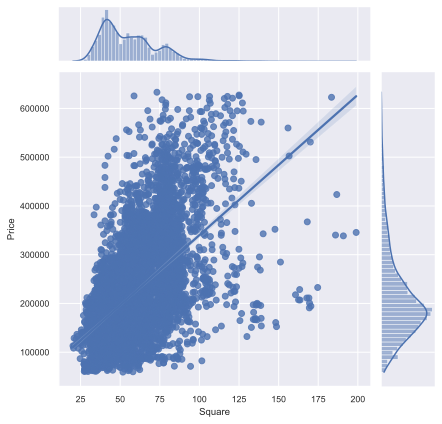

In [58]:
grid = sns.jointplot(X['Square'], X['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [59]:
X['LargeSquare'] = 0
X['LargeSquare'] = (X['Square'] > 120) * 1

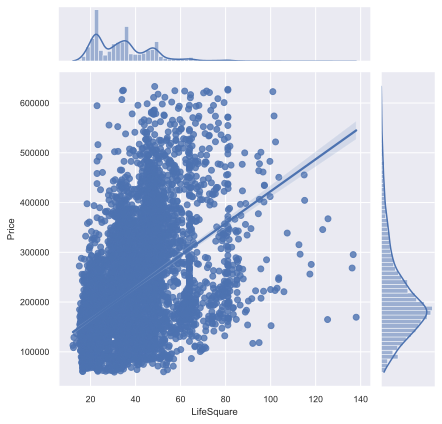

In [60]:
grid = sns.jointplot(X['LifeSquare'], X['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [61]:
X['LargeLifeSquare'] = 0
X['LargeLifeSquare'] = (X['LifeSquare'] > 90) * 1

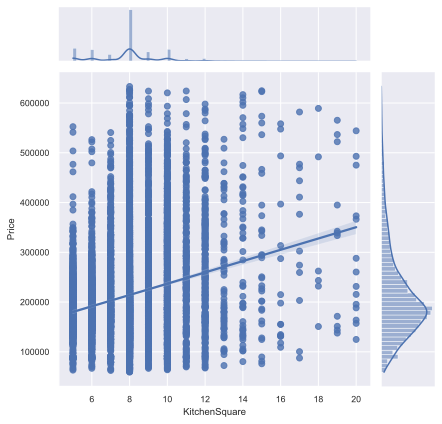

In [62]:
grid = sns.jointplot(X['KitchenSquare'], X['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

In [63]:
X['LargeKitchen'] = 0
X['LargeKitchen'] = (X['KitchenSquare'] > 14) * 1

In [64]:
class FeatureGenetator():
    """Generation of the new features"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.medsocial_2 = None
        self.district_size = None
        self.current_year = None
        self.medprice_by_room = None
        self.medprice_by_room_median = None
        self.medprice_by_agesquare = None
        self.medprice_by_agesquare_median = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        self.current_year = datetime.now().year
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        #Social_3
        self.medsocial_2 = X.groupby('Social_3', as_index=False).median()[['Social_3', 'Social_2']]
        self.medsocial_2 = pd.DataFrame(self.medsocial_2)
        self.medsocial_2.rename(columns={'Social_2': 'MedSocial_2'}, inplace=True)
        
        # DistrictID
        self.district_size = X.groupby('DistrictId').size()
        self.district_size = pd.DataFrame(self.district_size)
        self.district_size.rename(columns={0: 'DistrictSize'}, inplace=True)
                
        # Target encoding   
        df = X.copy()
        
        ## District, Rooms        
        if y is not None:
            df['Price'] = y.values
            
            self.medprice_by_room = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByRoom'})
            self.medprice_by_room_median = self.medprice_by_room['MedPriceByRoom'].median()
            
        ## AgeCat, SquareCat
        if y is not None:
            df['Price'] = y.values
            df = self.age_to_cat(df)
            df = self.square_to_cat(df)
            self.medprice_by_agesquare = df.groupby(['AgeCat', 'SquareCat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByAgeSquare'})
            self.medprice_by_agesquare_median = self.medprice_by_agesquare['MedPriceByAgeSquare'].median()

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)
        
        # Social_3
        X = X.merge(self.medsocial_2, on='Social_3', how='left')

        X['new_Social_3'] = 0
        X.loc[X['MedSocial_2'].isna(), 'new_district'] = 1
        
        X['MedSocial_2'].fillna(-1, inplace=True)        
        
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(0, inplace=True)
        
        # More categorical features        
        X = self.age_to_cat(X)  # + column AgeCat
        X = self.square_to_cat(X)   # + column SquareCat
        
        # 'Large'features
        X['LargeSquare'] = 0
        X['LargeSquare'] = (X['Square'] > 120) * 1
        
        X['LargeLifeSquare'] = 0
        X['LargeLifeSquare'] = (X['LifeSquare'] > 90) * 1
        
        X['LargeKitchen'] = 0
        X['LargeKitchen'] = (X['KitchenSquare'] > 14) * 1
        
        # Target encoding
        if self.medprice_by_room is not None:
            X = X.merge(self.medprice_by_room, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByRoom'].fillna(self.medprice_by_room_median, inplace=True)
            
        if self.medprice_by_agesquare is not None:
            X = X.merge(self.medprice_by_agesquare, on=['AgeCat', 'SquareCat'], how='left')
            X['MedPriceByAgeSquare'].fillna(self.medprice_by_agesquare_median, inplace=True)
        
        return X
    
    def age_to_cat(self, X):
        X['HouseAge'] = self.current_year - X['HouseYear']
        X['AgeCat'] = pd.cut(X['HouseAge'], bins = (-1, 5, 10, 20, 30, 40, 50, 10000), labels = False)

        X['AgeCat'].fillna(-1, inplace=True)
        return X
     
    def square_to_cat(self, X):
        X['SquareCat'] = pd.cut(X['Square'], bins = (-1, 30, 50, 70, 90, 110, 10000), labels = False)

        X['SquareCat'].fillna(-1, inplace=True)
        return X

### Model Creation

##### Train/test separation

In [65]:
import catboost as cb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

In [66]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [67]:
X.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'KitchenSquare_outlier',
 'Healthcare_1_outlier',
 'HouseYear_outlier',
 'MedSocial_2',
 'DistrictSize',
 'new_district',
 'HouseAge',
 'AgeCat',
 'SquareCat',
 'MedPriceByRoom',
 'MedPriceByAgeSquare',
 'LargeSquare',
 'LargeLifeSquare',
 'LargeKitchen']

In [68]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['LifeSquare_nan', 'Healthcare_1_nan', 'Rooms_outlier', 'HouseFloor_outlier', 'Square_outlier', 
                     'LifeSquare_outlier', 'KitchenSquare_outlier', 'Healthcare_1_outlier', 'HouseYear_outlier',
                     'MedSocial_2', 'DistrictSize', 'new_district', 'MedPriceByRoom', 'MedPriceByAgeSquare', 
                     'LargeSquare', 'LargeLifeSquare', 'LargeKitchen']

target_name = 'Price'

In [98]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [100]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [101]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 40), (3300, 40), (5000, 40))

In [102]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [103]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

##### Scaling the datasets

In [104]:
reduce_mem_usage(X_train)
reduce_mem_usage(X_valid)
reduce_mem_usage(test_df)

Memory usage of dataframe is 1.66 MB
Memory usage after optimization is: 0.49 MB
Decreased by 70.8%
Memory usage of dataframe is 0.82 MB
Memory usage after optimization is: 0.25 MB
Decreased by 70.0%
Memory usage of dataframe is 1.24 MB
Memory usage after optimization is: 0.37 MB
Decreased by 70.0%


Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0       1.0  36.847630   19.094183            5.0      5         9.0   
1       1.0  42.493908   32.546001           10.0      7        17.0   
2       2.0  59.463676   48.487110            9.0     19        19.0   
3       3.0  49.646030   33.893826            6.0      2         2.0   
4       1.0  53.837055   36.603798            8.0      8        17.0   
...     ...        ...         ...            ...    ...         ...   
4995    2.0  43.177521   30.339945            5.0      2         5.0   
4996    3.0  93.698120   32.546001           10.0     21        27.0   
4997    1.0  33.656723   19.003260            5.0      2         5.0   
4998    1.0  38.635155   20.976257            9.0      8        14.0   
4999    2.0  67.122742   33.944344           13.0      9        17.0   

      HouseYear  Ecology_1  Ecology_2  Ecology_3  ...  Healthcare_1_outlier  \
0          1970   0.036122          1          1  ...                     0   
1          2017   0.072158          1          1  ...                     0   
2          1977   0.211401          1          1  ...                     0   
3          1965   0.014073          1          1  ...                     0   
4          1977   0.309479          1          1  ...                     0   
...         ...        ...        ...        ...  ...                   ...   
4995       1962   0.069660          1          1  ...                     0   
4996       2018   0.060753          1          1  ...                     0   
4997       1966   0.038693          1          1  ...                     0   
4998       1970   0.089040          1          1  ...                     0   
4999       2009   0.194489          1          1  ...                     0   

      HouseYear_outlier  MedSocial_2  DistrictSize  new_district  \
0                     0       1564.0          70.0             0   
1                     0       5776.0         164.0             0   
2                     0       1564.0         568.0             0   
3                     0       1564.0         375.0             0   
4                     0       7715.0          76.0             0   
...                 ...          ...           ...           ...   
4995                  0       7715.0          59.0             0   
4996                  0       4789.0          25.0             0   
4997                  0       5776.0          69.0             0   
4998                  0       7010.0          35.0             0   
4999                  0       5735.0         120.0             0   

      MedPriceByRoom  MedPriceByAgeSquare  LargeSquare  LargeLifeSquare  \
0      167155.984375        180434.890625            0                0   
1      128808.351562        135588.218750            0                0   
2      164457.437500        190962.531250            0                0   
3      157606.062500        180434.890625            0                0   
4      162138.531250        190962.531250            0                0   
...              ...                  ...          ...              ...   
4995   182289.750000        180434.890625            0                0   
4996   419315.937500        382097.437500            0                0   
4997   148430.875000        180434.890625            0                0   
4998   166024.531250        180434.890625            0                0   
4999   183534.531250        260200.156250            0                0   

      LargeKitchen  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
4995             0  
4996             0  
4997             0  
4998             0  
4999             0  

[5000 rows x 34 columns]

In [76]:
feature_names_for_stand = X_train.select_dtypes(include=['float64', 'float32', 'float16']).columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1',
 'MedSocial_2',
 'MedPriceByRoom',
 'MedPriceByAgeSquare']

In [77]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [78]:
X_train[feature_names_for_stand] = stand_features_train
X_valid[feature_names_for_stand] = stand_features_valid
test_df[feature_names_for_stand] = stand_features_test

In [79]:
X_train.head()

Rooms    Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0  1.379967  0.942489    2.693783      -0.508150     15    0.513098   
1  0.143074 -0.969077   -0.637130      -1.029131      3   -0.129624   
2  0.143074  0.193052    0.071580       1.054791      7    0.673779   
3  0.143074 -0.985826   -0.863353      -1.029131      7    0.191737   
4 -1.093820 -0.853672   -0.967708       0.012830     20    1.477181   

   HouseYear  Ecology_1  Ecology_2  Ecology_3  ...  Healthcare_1_outlier  \
0       1976  -0.970496          1          1  ...                     0   
1       1969  -0.057234          1          1  ...                     0   
2       1999  -0.231082          1          1  ...                     0   
3       1970  -0.565314          1          1  ...                     0   
4       2019   0.775549          1          1  ...                     0   

   HouseYear_outlier  MedSocial_2  DistrictSize  new_district  MedPriceByRoom  \
0                  0     0.524467            18             0        1.558975   
1                  0     0.190948            24             0        0.942244   
2                  0     0.088681            66             0        0.434277   
3                  0     0.543354            26             0       -0.003316   
4                  0    -1.396950           568             0       -1.213510   

   MedPriceByAgeSquare  LargeSquare  LargeLifeSquare  LargeKitchen  
0             0.379491            0                0             0  
1            -0.383550            0                0             0  
2             0.576150            0                0             0  
3            -0.383550            0                0             0  
4            -1.088804            0                0             0  

[5 rows x 34 columns]

In [80]:
#with open(MODEL_FILE_PATH + 'scaler.pkl', 'wb') as file:
    #pickle.dump(scaler, file)

##### Gradient Boosting Model

Train R2:	0.804
Test R2:	0.66


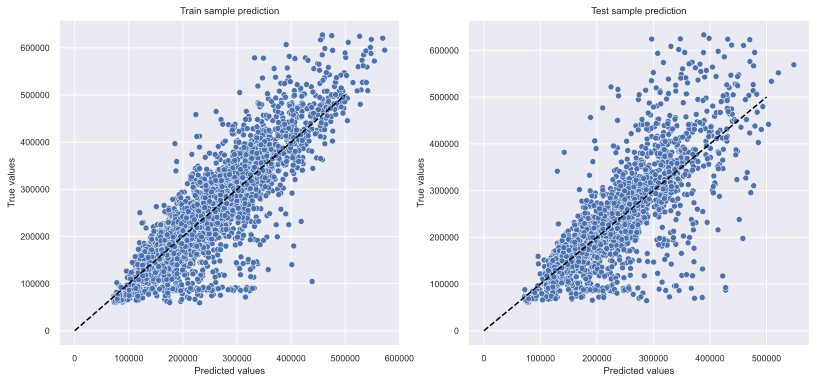

In [81]:
gb = GradientBoostingRegressor(criterion='mse', random_state=42)
gb.fit(X_train, y_train)

y_train_preds = gb.predict(X_train)
y_valid_preds = gb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [82]:
feature_importances_gb = pd.DataFrame(zip(X_train.columns, gb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances_gb.sort_values(by='importance', ascending=False)

feature_name  importance
29         MedPriceByRoom    0.748503
30    MedPriceByAgeSquare    0.070735
1                  Square    0.061794
3           KitchenSquare    0.029767
27           DistrictSize    0.018125
5              HouseFloor    0.013512
10               Social_1    0.008792
12               Social_3    0.006743
6               HouseYear    0.006731
0                   Rooms    0.005864
2              LifeSquare    0.004642
7               Ecology_1    0.004172
11               Social_2    0.004159
13           Healthcare_1    0.003535
4                   Floor    0.003398
23  KitchenSquare_outlier    0.001593
15                Shops_1    0.001477
24   Healthcare_1_outlier    0.001318
21         Square_outlier    0.001273
22     LifeSquare_outlier    0.000953
14            Helthcare_2    0.000910
26            MedSocial_2    0.000802
18       Healthcare_1_nan    0.000707
9               Ecology_3    0.000373
31            LargeSquare    0.000122
32        LargeLifeSquare    0.000000
28           new_district    0.000000
17         LifeSquare_nan    0.000000
25      HouseYear_outlier    0.000000
20     HouseFloor_outlier    0.000000
19          Rooms_outlier    0.000000
16                Shops_2    0.000000
8               Ecology_2    0.000000
33           LargeKitchen    0.000000

In [83]:
trash_features_gb = feature_importances_gb.loc[(feature_importances_gb['importance']<0.002) | (feature_importances_gb['importance']>0.07), 
                        'feature_name'].to_list()

In [84]:
X_train_gb = X_train.drop(columns = trash_features_gb)
X_valid_gb = X_valid.drop(columns = trash_features_gb)
test_df_gb = test_df.drop(columns = trash_features_gb)

In [85]:
%%time
params = {'n_estimators':[50, 100, 200], 
          'max_depth':[4, 10, 20],
          'min_samples_leaf':[20, 30, 40]}

gs = GridSearchCV(gb, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train_gb, y_train)

Wall time: 1min 16s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 10, 20],
                         'min_samples_leaf': [20, 30, 40],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [86]:
gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 30, 'n_estimators': 200}

In [87]:
gs.best_score_

0.6797641515165065

Train R2:	0.755
Test R2:	0.691


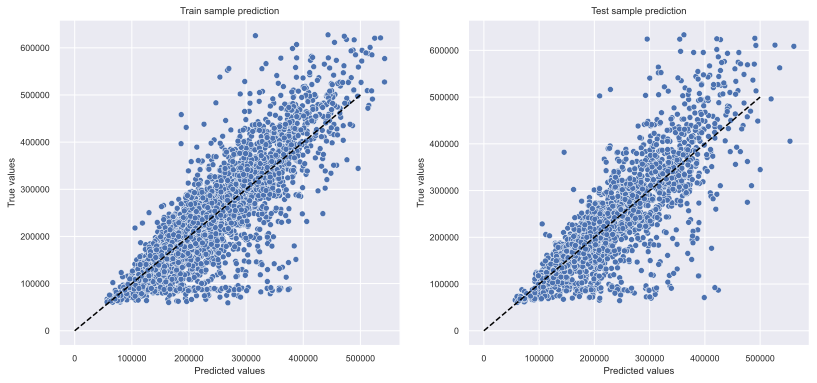

In [96]:
gb = GradientBoostingRegressor(criterion='mse', 
                               max_depth = 4,
                               min_samples_leaf = 30,
                               n_estimators = 200,
                               random_state=42)
gb.fit(X_train_gb, y_train)

y_train_preds = gb.predict(X_train_gb)
y_valid_preds = gb.predict(X_valid_gb)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [89]:
cv_score = cross_val_score(gb, X_train_gb, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.63614398, 0.64902646, 0.71823994, 0.69540609, 0.68973189])

In [90]:
with open(MODEL_FILE_PATH + 'gb_model.pkl', 'wb') as file:
    pickle.dump(gb, file)

##### Creating Predictions for test

In [91]:
submit_gb = pd.read_csv(SUBMIT_DATASET_PATH)
submit_gb.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [92]:
predictions_gb = gb.predict(test_df_gb)
submit_gb['Price'] = predictions_gb
submit_gb.head()

Id          Price
0  4567  168336.303483
1  5925  133142.062910
2   960  145575.700920
3  3848  119086.881558
4   746  212756.852244

In [93]:
#submit_gb.to_csv('gb_model.csv', index=False)